### Modelo 1

In [73]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
^C
make: *** No rule to make target 'install'.  Stop.


In [116]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
import metnum
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [117]:
df = pd.read_csv("../data/expectativa_de_vida_procesado.csv")
df

,Country,Life expectancy,Adult Mortality,Infant Mortality,Alcohol,Hepatitis B,Measles,Under five Mortality,Polio,Total expenditure,...,Population,thinness 10-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status,Diseases Mortality,Child Mortality,Mortality Rate,Suicide Rates
0,Albania,75.15625,3.808050,2.724784,4.848750,98.000000,53.3750,2.840503,4.586242,1.782656,...,6.969116e+05,1.61875,1.70000,0.709875,2.496300,Developing,17.678750,3.094375,12.467713,6.116875
1,Algeria,73.61875,4.683866,3.286651,0.406667,78.000000,1943.8750,3.439917,4.519067,1.526925,...,2.164983e+07,6.09375,5.97500,0.694875,2.542586,Developing,15.878750,4.830000,16.240434,3.521875
2,Angola,49.01875,5.794727,4.484329,5.740667,70.222222,3561.3125,4.969123,3.831355,1.365922,...,1.014710e+07,6.19375,6.66875,0.458375,2.084895,Developing,25.848750,30.855625,46.103804,15.413125
3,Antigua and Barbuda,75.05625,4.848116,2.290449,7.949333,98.266667,0.0000,2.443922,4.574066,1.566809,...,NaN,3.42500,3.37500,0.488625,2.179711,Developing,18.258750,2.398750,11.981237,0.751250
4,Argentina,75.15625,4.663439,2.628060,7.966667,81.285714,2.0000,2.741001,4.536624,1.933355,...,2.012120e+07,1.07500,0.95000,0.794125,2.803739,Developing,18.410625,2.578125,12.610625,8.864375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,Vanuatu,71.38750,4.926347,3.185371,0.806667,56.125000,20.8750,3.364339,4.192492,1.368300,...,1.230962e+05,1.56875,1.49375,0.367500,2.357902,Developing,40.310625,5.921250,17.397307,22.058125
166,Venezuela (Bolivarian Republic of),73.38750,5.093750,2.763643,7.420000,66.250000,165.0000,2.917771,4.313313,1.609171,...,NaN,1.65000,1.56250,0.726812,2.548468,Developing,16.552500,3.676250,14.451414,4.250625
167,Viet Nam,74.77500,4.840736,2.966979,3.087333,87.538462,4232.9375,3.194660,4.553219,1.787975,...,NaN,14.92500,15.62500,0.627063,2.443433,Developing,21.995000,4.334375,15.336750,7.252500
168,Yemen,63.86250,5.355701,3.936703,0.047333,55.687500,2761.1875,4.216636,4.206557,1.610504,...,NaN,13.83125,13.75000,0.475500,2.140801,Developing,28.447500,8.978750,22.487791,7.687500


In [118]:
def adjusted_r2(p, fitted, target):
    n=len(target)
    return 1 - (1-r2_score(target, fitted)) * (n-1) / (n-p-1)

def correr_analisis(predictors, dataset):
    target = dataset['Life expectancy'].to_numpy()
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    model = metnum.LinearRegression()
    matrix = model.fit(features, target)
    fitted = model.predict(features)

    diagnostico_residuos(predictors, dataset)
    
    return {
        'r2':r2_score(target, fitted),
        'r2 adjustado':adjusted_r2(p, fitted, target),
        'MSE': mean_squared_error(target, fitted),
        'MSLE': mean_squared_log_error(target, fitted)
    }

def rmse(fitted, target):
    rmse = np.sqrt(mean_squared_error(target, fitted))
    return rmse

def standarized_residual_plot(predicted, actual, fname):
    residuals = actual - predicted
    standarized_residuals = residuals/np.std(residuals)
    plt.scatter(predicted, standarized_residuals)
    plt.xlabel("Predicciones")
    plt.ylabel("Residuos estandarizados")
    plt.hlines(0, xmin=min(predicted), xmax=max(predicted), color='red')
    plt.title("Residuos estandarizados",  fontsize = 15)
    plt.savefig(fname)
    return standarized_residuals

def ols_influence(lm, fname):
    plt.figure(figsize=(30,30))
    sm.graphics.influence_plot(lm, alpha = 0.05, criterion="cooks")
    plt.savefig(fname)
    plt.show()

def cooks_dist(lm, fname):
    plt.figure(figsize=(15,7))
    influence = lm.get_influence()
    cooks = influence.cooks_distance
    plt.stem(range(len(cooks[0])), cooks[0])
    plt.axhline(y=0.5, color='r', linestyle='-')
    plt.margins(x=0)
    plt.xlabel('ID País')
    plt.ylabel('Cooks Distance')
    plt.title("Cooks Distance",  fontsize = 15)
    plt.savefig(fname)
    plt.show()

def qqplot(lm, fname):
    plt.figure(figsize=(30,30))
    sm.qqplot(lm.resid, line='r')
    plt.title("Q-Q residuos del modelo",  fontsize = 15)
    plt.savefig(fname)
    plt.show()

def histplot(lm,fname):
    plt.figure(figsize=(10,7))
    sns.histplot(
        data    = lm.resid,
        stat    = "density",
        kde     = True,
        color = "darkred",
        line_kws= {'linewidth': 1},
        alpha   = 0.3,
        binrange = (-15,15)
    )
    plt.title("Distribución residuos del modelo",  fontsize = 15)
    plt.savefig(fname)
    plt.show()

def run_analysis(predictors, dataset, number):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    fitted = regr.predict(features)

    print(regr.summary())

    #Filename para guardar los plots 
    ext = '.svg'
    folder = 'images/model-graphics'
    
    standarized_residuals = standarized_residual_plot(fitted, target, f'{folder}/residual_plot_model_{number}{ext}')
    ols_influence(regr, f'{folder}/influence_plot_model_{number}{ext}')
    cooks_dist(regr, f'{folder}/cooks_dist_model_{number}{ext}')
    qqplot(regr, f'{folder}/qq_plot_model_{number}{ext}')
    histplot(regr, f'{folder}/dist_plot_model_{number}{ext}')

    return {
        'model': regr,
        'r2':r2_score(target, fitted),
        'rmse':rmse(fitted, target),
        'adjusted':adjusted_r2(p, fitted, target),
        'AIC': regr.aic,
        'BIC': regr.bic
    }

In [119]:
def diagnostico_residuos(predictors, dataset):
    actual = dataset['Life expectancy'].to_numpy()
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    model = metnum.LinearRegression()
    matrix = model.fit(features, actual)
    predicted = model.predict(features)

    residuos = predicted - actual
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

    axes[0, 0].scatter(actual, predicted, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[0, 0].plot([actual.min(), actual.max()], [actual.min(), actual.max()],
                    'k--', lw=2)
    axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
    axes[0, 0].set_xlabel('Real')
    axes[0, 0].set_ylabel('Predicción')
    axes[0, 0].tick_params(labelsize = 7)

    axes[0, 1].scatter(list(range(len(actual))), residuos,
                    edgecolors=(0, 0, 0), alpha = 0.4)
    axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
    axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[0, 1].set_xlabel('id')
    axes[0, 1].set_ylabel('Residuo')
    axes[0, 1].tick_params(labelsize = 7)

    sns.histplot(
        data    = residuos,
        stat    = "density",
        kde     = True,
        line_kws= {'linewidth': 1},
        color   = "darkorange",
        alpha   = 0.3,
        ax      = axes[1, 0]
    )

    axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                        fontweight = "bold")
    axes[1, 0].set_xlabel("Residuo")
    axes[1, 0].tick_params(labelsize = 7)


    sm.qqplot(
       residuos,
        fit   = True,
        line  = 'q',
        ax    = axes[1, 1], 
        color = 'firebrick',
        alpha = 0.4,
        lw    = 2
    )
    axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[1, 1].tick_params(labelsize = 7)

    axes[2, 0].scatter(predicted,residuos,
                    edgecolors=(0, 0, 0), alpha = 0.4)
    axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
    axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
    axes[2, 0].set_xlabel('Predicción')
    axes[2, 0].set_ylabel('Residuo')
    axes[2, 0].tick_params(labelsize = 7)

    standarized_residuals = residuos/np.std(residuos)
    axes[2, 1].scatter(predicted,standarized_residuals,
                    edgecolors=(0, 0, 0), alpha = 0.4)
    axes[2, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
    axes[2, 1].set_title('Residuos estandarizados vs predicción', fontsize = 10, fontweight = "bold")
    axes[2, 1].set_xlabel('Predicción')
    axes[2, 1].set_ylabel('Residuos estandarizados')
    axes[2, 1].tick_params(labelsize = 7)

    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold")

Para guardar los valores de AIC y BIC de todos los modelos

In [120]:
aic_values, bic_values = [], []

### Variables que tenemos en cuenta para nuestro modelo:
GDP, Adult Mortality, thinness 10-19 y thinness 5-9, Schooling, Under five mortality, Infant Mortality

Estas métricas fueron las dadas, luego agregamos otro indicador de Child Mortality para completar el rango de edad faltante y queremos probar sumando todas esas metricas que correlacion tiene y como cambia el modelo. 

Sumar las dos thinness porque tienen la misma correlacion y representan un rango. 


### Combinamos variables 

### Modelo v1
Tomamos los indicadores principales que tienen mejor correlación con el target. 
Resultado: El modelo dio un r^2 muy elevado, al igual que el r^2 ajustado. Sin embargo si observamos los valores de VIF superan lo permitido, lo cual implica que los features elegidos están muy correlacionados entre si, lo cual puede estar inflando el valor de r^2 y haciendo que nuestro modelo sea más complejo de lo que debería. 
Vemos algunos outliers en los graficos de residuos estandarizados, pero no son demasiados. 


VIF for GDP 107.74820036265076
VIF for Adult Mortality 185.95857163100501
VIF for thinness 10-19 years 79.603048202263
VIF for thinness 5-9 years 76.97186325512122
VIF for Schooling 170.3366026037866
VIF for Under five Mortality 1411.3025822571103
VIF for Infant Mortality 1271.8640262158392
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     342.0
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           1.44e-93
Time:                        21:50:59   Log-Likelihood:                -378.88
No. Observations:                 170   AIC:                             773.8
Df Residuals:                     162   BIC:                             798.9
Df Model:                           7                                       

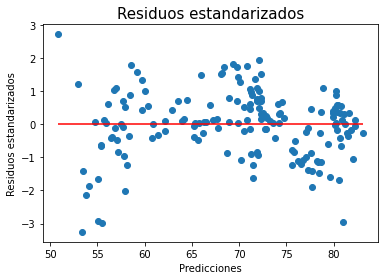

<Figure size 2160x2160 with 0 Axes>

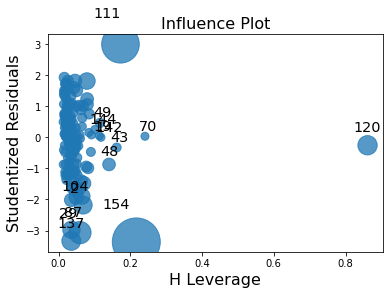

/home/sebastian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


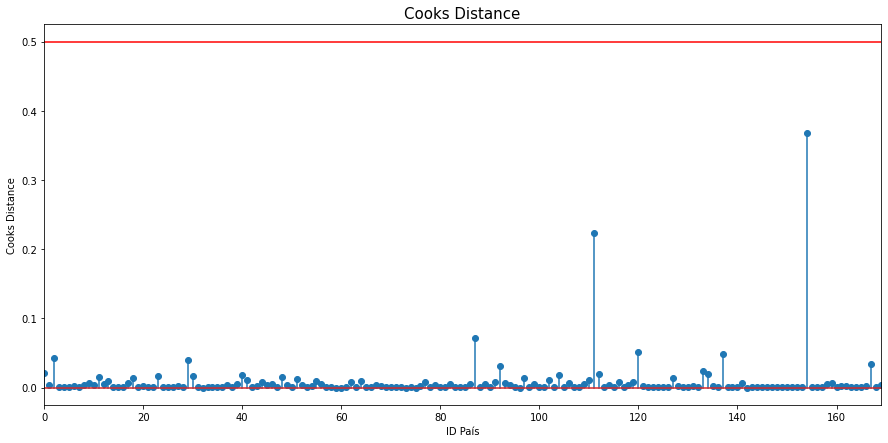

<Figure size 2160x2160 with 0 Axes>

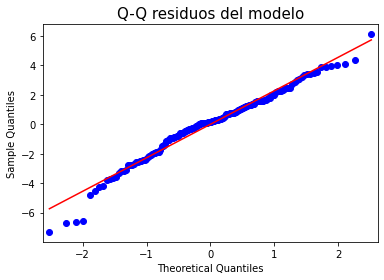

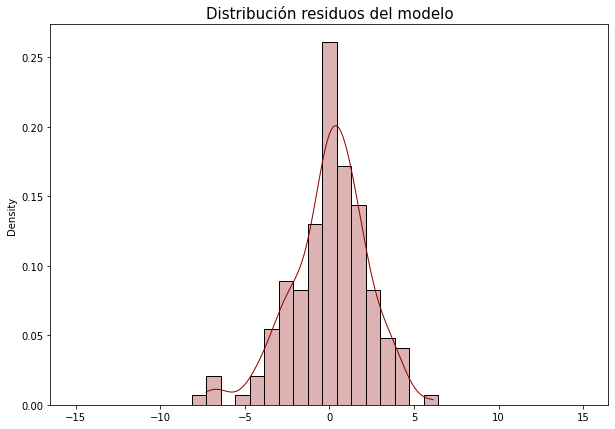

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f8486eb2fd0>,
 'r2': 0.9366240545283366,
 'rmse': 2.2474144560753793,
 'adjusted': 0.9338855877486969,
 'AIC': 773.7644457305348,
 'BIC': 798.8508332269369}

In [121]:
indicators_v1 = ['GDP', 'Adult Mortality', 'thinness 10-19 years', 'thinness 5-9 years', 'Schooling', 'Under five Mortality', 'Infant Mortality']
v1_values = run_analysis(indicators_v1, df, 1)
aic_values.append(v1_values['AIC'])
bic_values.append(v1_values['BIC'])
v1_values

### Modelo v2 
Buscamos agrupar las variables con significado similar y ver si podemos disminuir el VIF. Agrupamos las dos métricas de thinness en Young thinness porque los rangos de edad son dijuntos y están en la misma unidad. Agregamos la variable Child Mortality para poder agrupar mortalidad entre rango de edad de 1 a 60 años, creamos el nuevo indicador Mortality Rate. Obtuvimos un r^2 y r^2 ajustado más bajo, a pesar que mejoraron los indicadores VIF para algunas variables, aunque sigue alto para GDP y Schooling probablemente porque ambos indicadores están muy correlacionados entre ellos.

In [122]:
df['Young thinness'] = df['thinness 10-19 years'] + df['thinness 5-9 years']

VIF for Mortality Rate 4.5307152429714
VIF for Young thinness 3.178492795353484
VIF for GDP 91.17563720254286
VIF for Schooling 103.6414692167867
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     262.5
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           2.08e-70
Time:                        21:51:01   Log-Likelihood:                -443.65
No. Observations:                 170   AIC:                             897.3
Df Residuals:                     165   BIC:                             913.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.0

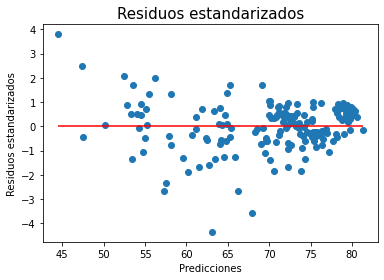

<Figure size 2160x2160 with 0 Axes>

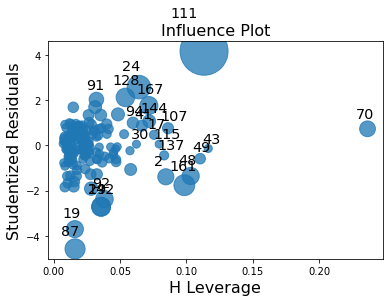

/home/sebastian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


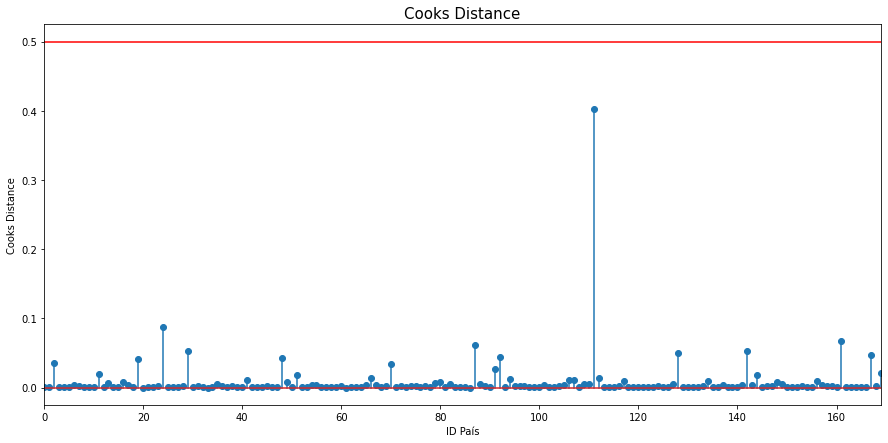

<Figure size 2160x2160 with 0 Axes>

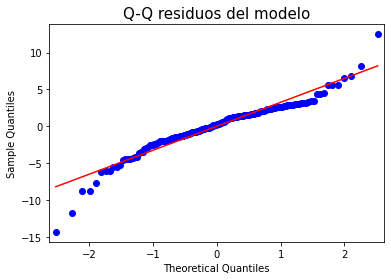

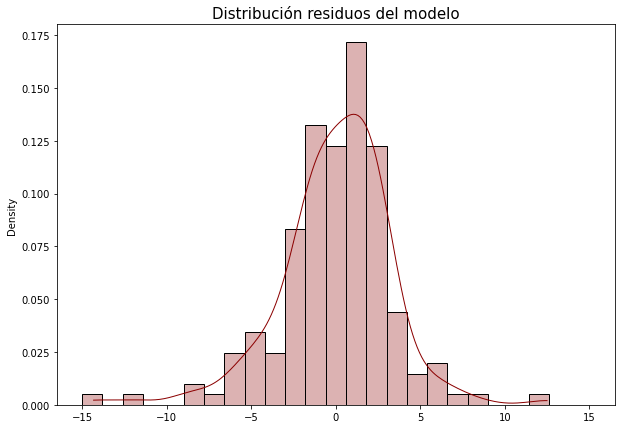

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f8485fd9e48>,
 'r2': 0.8642168622437812,
 'rmse': 3.289605844334899,
 'adjusted': 0.8609251498133275,
 'AIC': 897.3001374614544,
 'BIC': 912.9791296467057}

In [123]:

indicators_v2 = ['Mortality Rate', 'Young thinness', 'GDP', 'Schooling']
v2_values = run_analysis(indicators_v2, df,2) 
aic_values.append(v2_values['AIC'])
bic_values.append(v2_values['BIC'])
v2_values

### Modelo v3
Eliminamos del modelo GDP y dejamos Schooling, ya que el VIF era mayor a 10. No combinamos las variables porque pertenecen a escalas distintas, con lo cual no queda claro como generar un término de interacción entre ellas.

VIF for Mortality Rate 4.357580884012727
VIF for Young thinness 3.090097040288516
VIF for Schooling 2.9378623521256317
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     304.5
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           3.06e-67
Time:                        21:51:05   Log-Likelihood:                -454.22
No. Observations:                 170   AIC:                             916.4
Df Residuals:                     166   BIC:                             929.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------

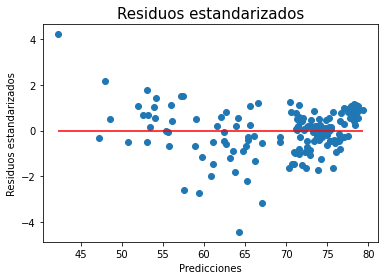

<Figure size 2160x2160 with 0 Axes>

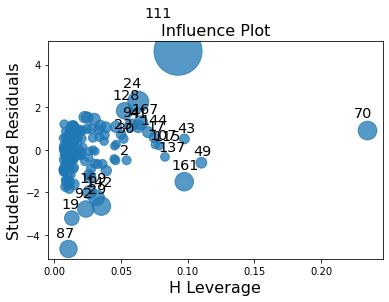

/home/sebastian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


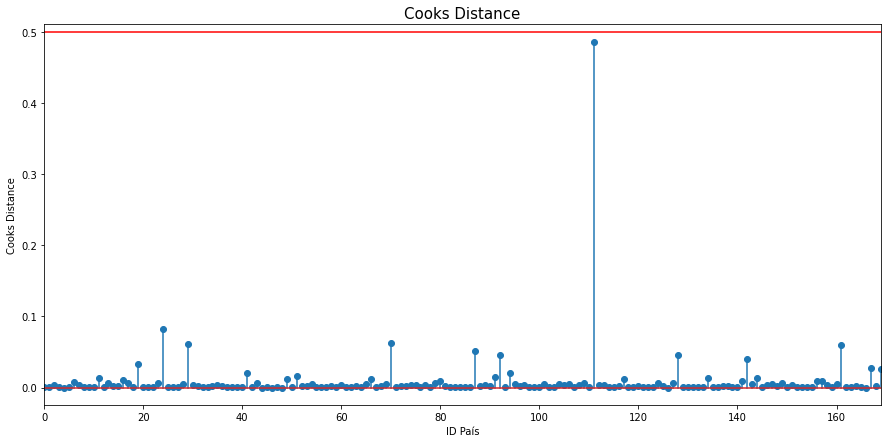

<Figure size 2160x2160 with 0 Axes>

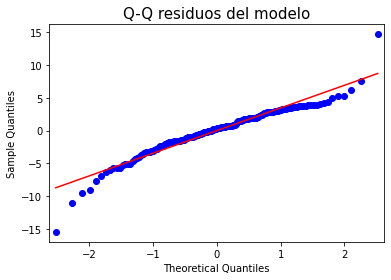

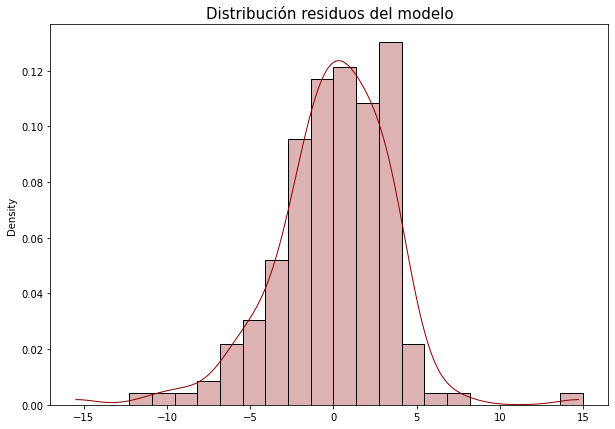

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f8485fd9978>,
 'r2': 0.846243083651738,
 'rmse': 3.500566034669367,
 'adjusted': 0.843464344199661,
 'AIC': 916.433492357216,
 'BIC': 928.976686105417}

In [124]:
indicators_v3 = ['Mortality Rate', 'Young thinness', 'Schooling']
v3_values = run_analysis(indicators_v3, df,3)
aic_values.append(v3_values['AIC'])
bic_values.append(v3_values['BIC'])
v3_values

### Modelo v4
Agregamos GDP y eliminamos Schooling.

VIF for Mortality Rate 4.164387091352033
VIF for Young thinness 3.0633927025549643
VIF for GDP 2.5845009144759308
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     351.6
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           1.16e-71
Time:                        21:51:11   Log-Likelihood:                -443.78
No. Observations:                 170   AIC:                             895.6
Df Residuals:                     166   BIC:                             908.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------

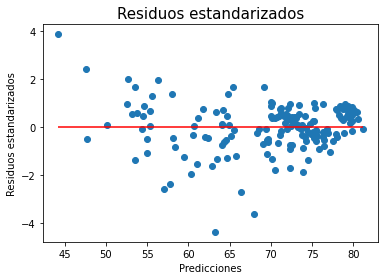

<Figure size 2160x2160 with 0 Axes>

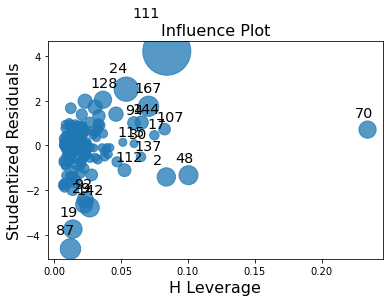

/home/sebastian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


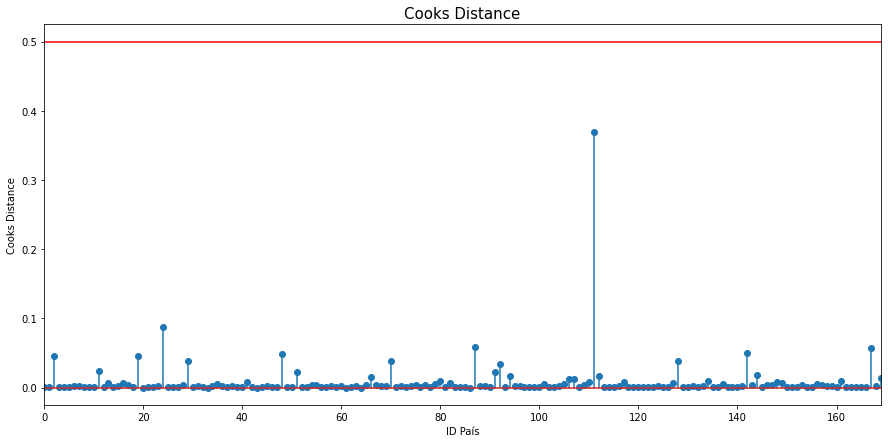

<Figure size 2160x2160 with 0 Axes>

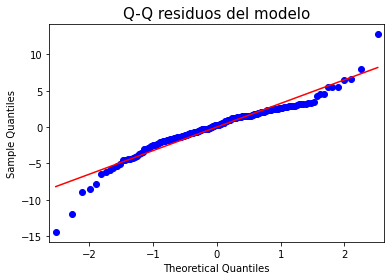

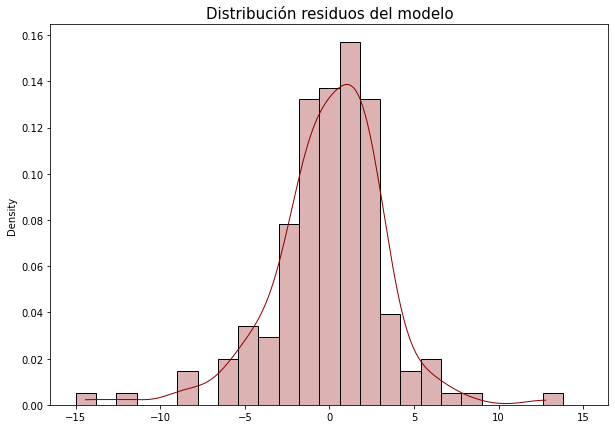

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f848723d390>,
 'r2': 0.8640103984201976,
 'rmse': 3.2921058845682567,
 'adjusted': 0.861552755018153,
 'AIC': 895.5584331010186,
 'BIC': 908.1016268492197}

In [125]:
indicators_v4 = ['Mortality Rate', 'Young thinness', 'GDP']
v4_values = run_analysis(indicators_v4, df,4)
aic_values.append(v4_values['AIC'])
bic_values.append(v4_values['BIC'])
v4_values

Tanto en el modelo v3 como en el modelo v4 resolvimos el problema de los VIF y observamos que GDP es un mejor predictor que Schooling. Probablemente esto se deba a que GDP tenga mejor correlacción con el target. 

### Modelo v5
Sacamos la variable que tiene menor correlación y dejamos el modelo con solo dos predictores. Vemos que el r^2 ajustado se reduce muy poco con lo cual podemos afirmar que este modelo predice casi tan bien como el anterior pero con menos variables.

VIF for Mortality Rate 2.5435198910419734
VIF for GDP 2.5435198910419747
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     526.5
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           7.73e-73
Time:                        21:51:14   Log-Likelihood:                -444.34
No. Observations:                 170   AIC:                             894.7
Df Residuals:                     167   BIC:                             904.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

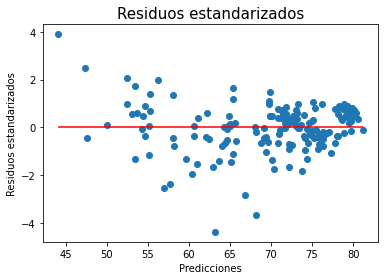

<Figure size 2160x2160 with 0 Axes>

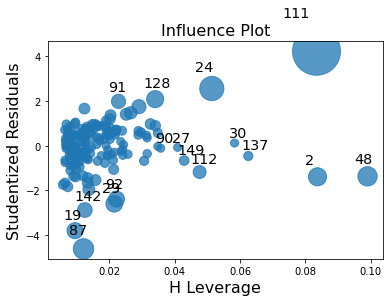

/home/sebastian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


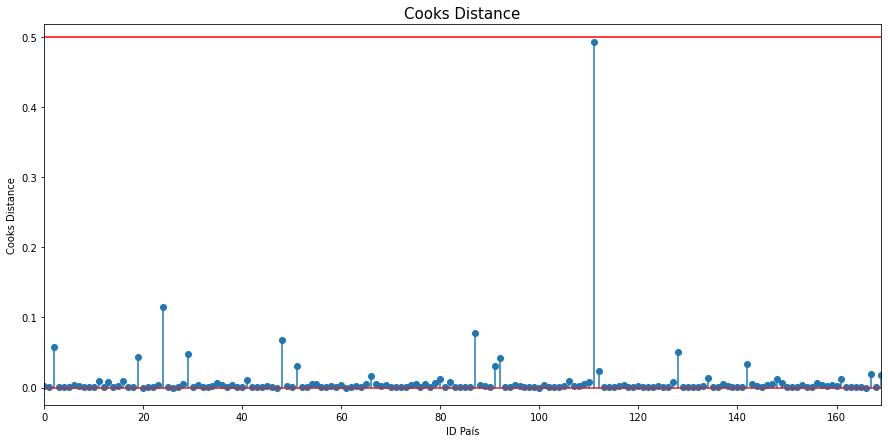

<Figure size 2160x2160 with 0 Axes>

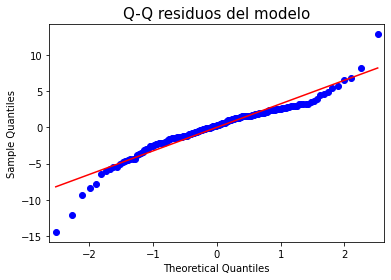

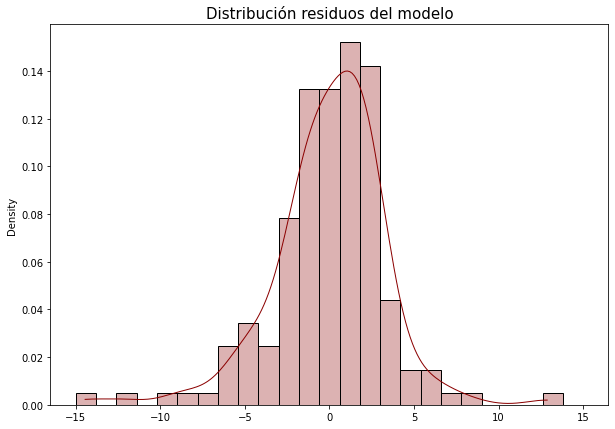

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f848615c8d0>,
 'r2': 0.8631056064991979,
 'rmse': 3.3030395611949688,
 'adjusted': 0.8614661526848171,
 'AIC': 894.6857633439582,
 'BIC': 904.093158655109}

In [126]:
indicators_v5 = ['Mortality Rate', 'GDP']
v5_values = run_analysis(indicators_v5, df,5)
aic_values.append(v5_values['AIC'])
bic_values.append(v5_values['BIC'])
v5_values

### Modelo v5.2

VIF for Mortality Rate 2.608770253722741
VIF for GDP 2.608770253722741
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     580.6
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           1.16e-75
Time:                        21:51:16   Log-Likelihood:                -433.56
No. Observations:                 169   AIC:                             873.1
Df Residuals:                     166   BIC:                             882.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

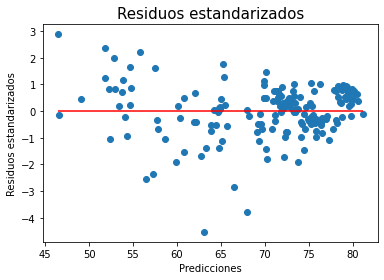

<Figure size 2160x2160 with 0 Axes>

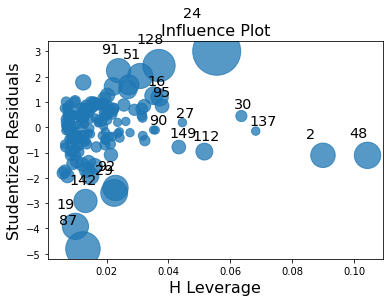

/home/sebastian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


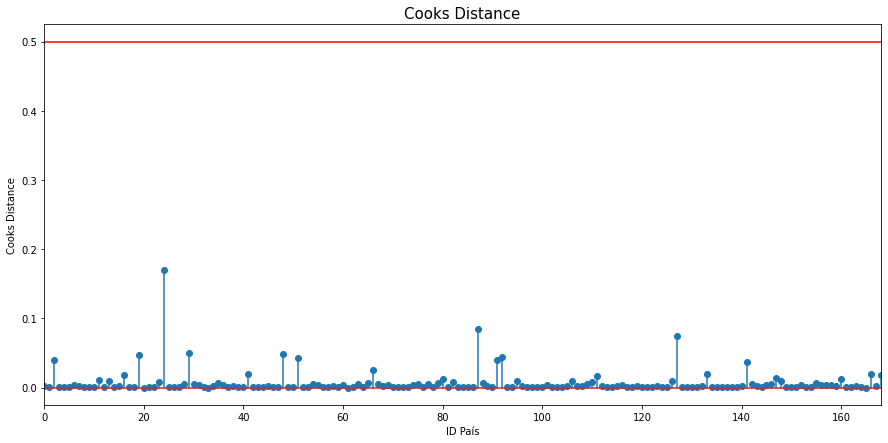

<Figure size 2160x2160 with 0 Axes>

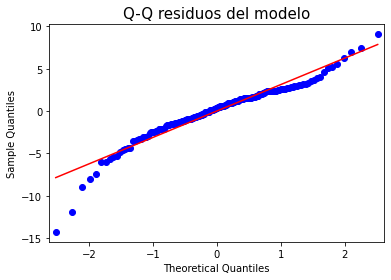

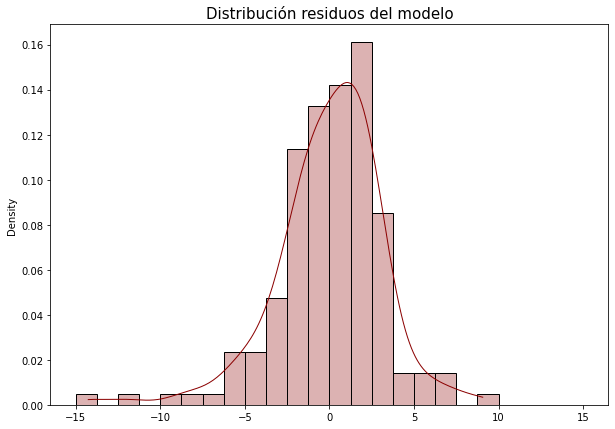

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f8485ff0630>,
 'r2': 0.8749235924636853,
 'rmse': 3.147125421031732,
 'adjusted': 0.8734166477945731,
 'AIC': 873.1146655715906,
 'BIC': 882.5043617163599}

In [127]:
df.drop(df.index[df['Country'] == "Niger"],inplace=True)

indicators_v52 = ['Mortality Rate', 'GDP']
v52_values = run_analysis(indicators_v52, df, 5)
aic_values.append(v5_values['AIC'])
bic_values.append(v5_values['BIC'])
v52_values

### Modelo v6 
Agregamos la variable categórica Status de cada país (si es desarrollado o no)

In [128]:
df['Binary Status'] = df['Status'].apply(lambda x: 0 if x=='Developing' else 1)

VIF for Mortality Rate 3.2320123671370524
VIF for GDP 4.301260942626027
VIF for Binary Status 1.7026723918839841
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     393.5
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           6.25e-75
Time:                        21:51:18   Log-Likelihood:                -431.89
No. Observations:                 169   AIC:                             871.8
Df Residuals:                     165   BIC:                             884.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

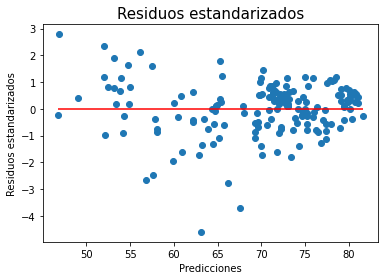

<Figure size 2160x2160 with 0 Axes>

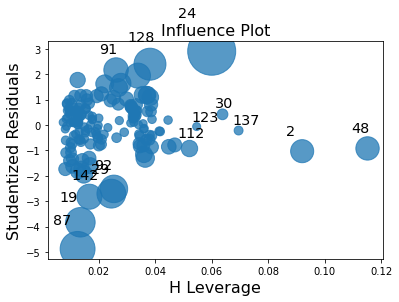

/home/sebastian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


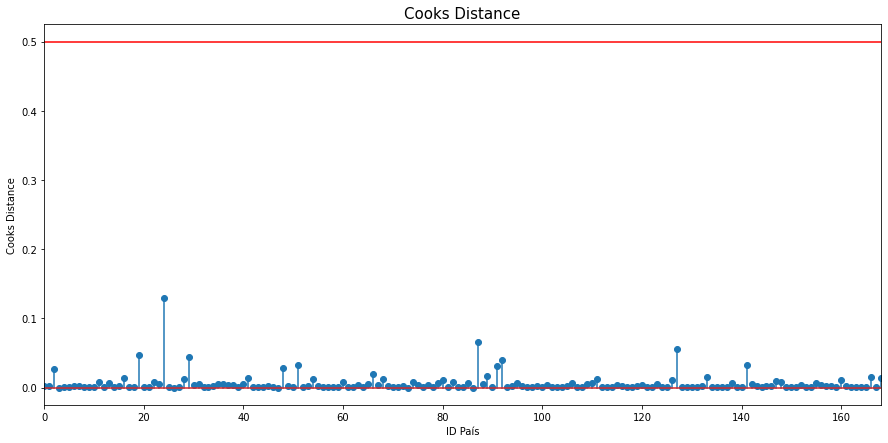

<Figure size 2160x2160 with 0 Axes>

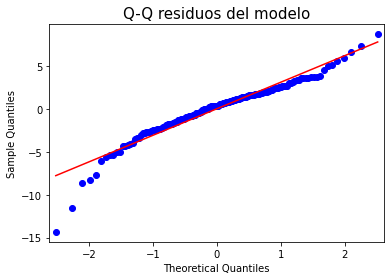

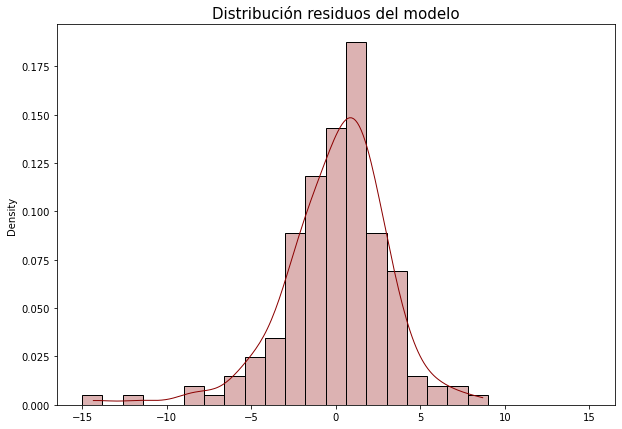

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f8486177128>,
 'r2': 0.8773637153557935,
 'rmse': 3.1162754904397523,
 'adjusted': 0.8751339647258989,
 'AIC': 871.785049278443,
 'BIC': 884.3046441381354}

In [129]:
indicators_v6 = ['Mortality Rate', 'GDP', 'Binary Status']
v6_values = run_analysis(indicators_v6, df,6)
aic_values.append(v6_values['AIC'])
bic_values.append(v6_values['BIC'])
v6_values

VIF for Mortality Rate 3.2320123671370524
VIF for GDP 4.301260942626027
VIF for Binary Status 1.7026723918839841
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     393.5
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           6.25e-75
Time:                        21:51:20   Log-Likelihood:                -431.89
No. Observations:                 169   AIC:                             871.8
Df Residuals:                     165   BIC:                             884.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

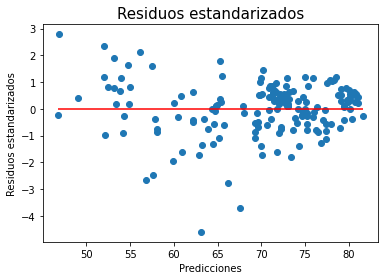

<Figure size 2160x2160 with 0 Axes>

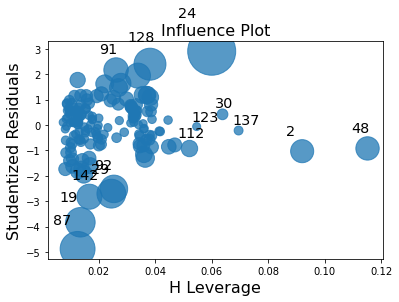

/home/sebastian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


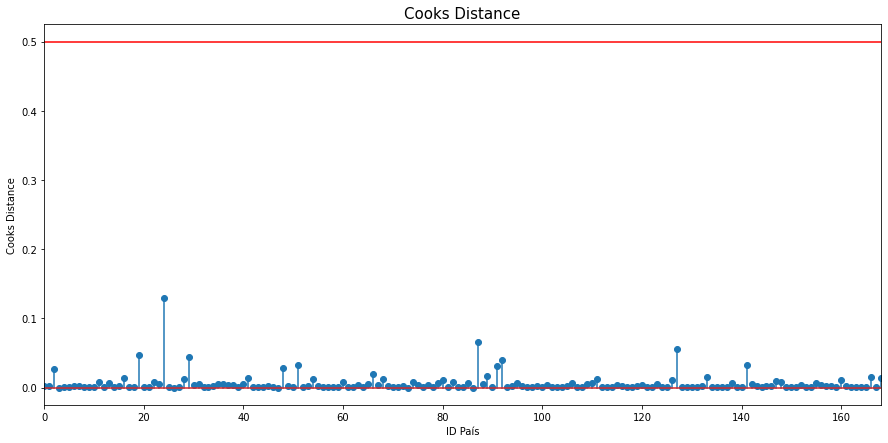

<Figure size 2160x2160 with 0 Axes>

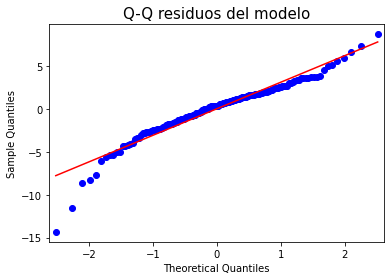

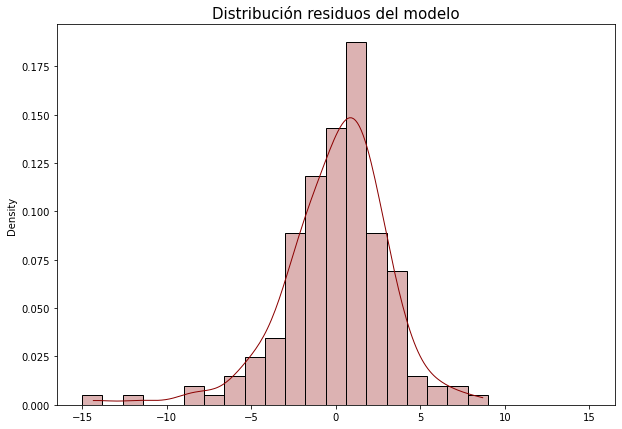

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f8486177710>,
 'r2': 0.8773637153557935,
 'rmse': 3.1162754904397523,
 'adjusted': 0.8751339647258989,
 'AIC': 871.785049278443,
 'BIC': 884.3046441381354}

In [130]:
indicators_v6 = ['Mortality Rate', 'GDP', 'Binary Status']
v6_values = run_analysis(indicators_v6, df,6)
aic_values.append(v6_values['AIC'])
bic_values.append(v6_values['BIC'])
v6_values

VIF for Mortality Rate 2.998968333027215
VIF for GDP 3.2667152790182987
VIF for Suicide Rates 2.8439294078293504
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     542.5
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           3.34e-85
Time:                        21:58:28   Log-Likelihood:                -407.65
No. Observations:                 169   AIC:                             823.3
Df Residuals:                     165   BIC:                             835.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

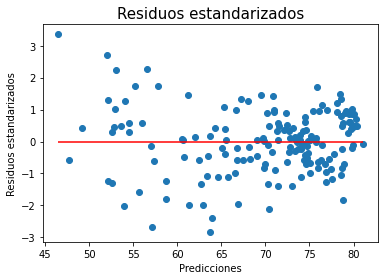

<Figure size 2160x2160 with 0 Axes>

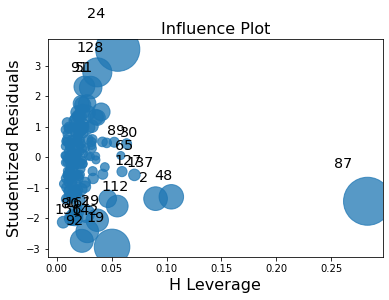

/home/sebastian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


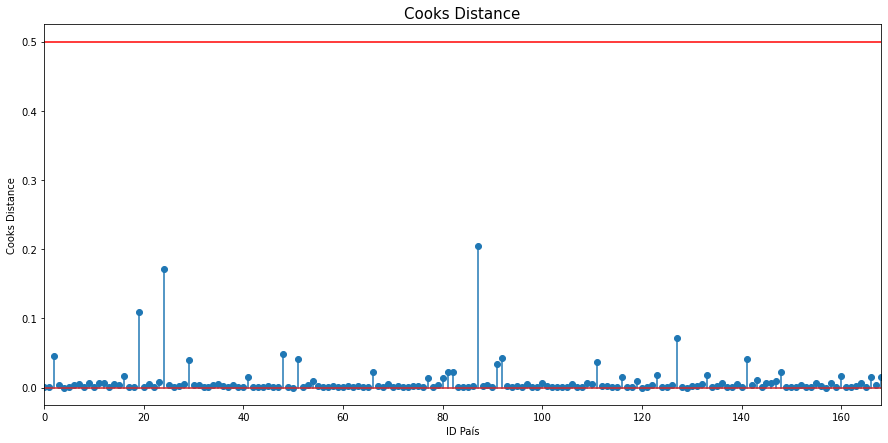

<Figure size 2160x2160 with 0 Axes>

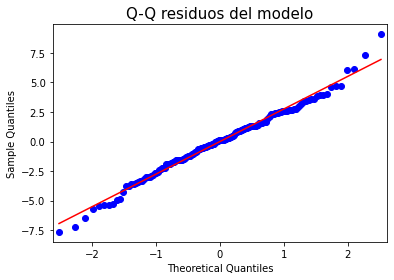

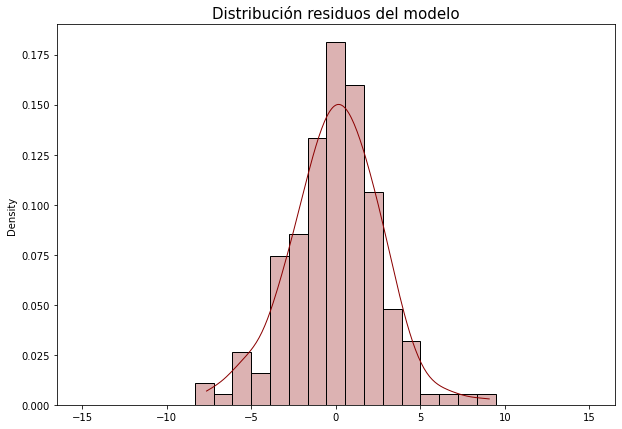

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f84861360f0>,
 'r2': 0.907948745301498,
 'rmse': 2.6998597713460986,
 'adjusted': 0.9062750861251616,
 'AIC': 823.3027684947712,
 'BIC': 835.8223633544635}

In [136]:
indicators_v7 = ['Mortality Rate', 'GDP', 'Suicide Rates']
v7_values = run_analysis(indicators_v7, df,6)
aic_values.append(v7_values['AIC'])
bic_values.append(v7_values['BIC'])
v7_values